## 問題統整

1. SAR (Suspicious Activity Report) 的比例不均
    * 洗錢 (sar = 1) 有 234 筆資料
    * 正常 (sar = 0) 有 23672 筆資料

2. ccba 中為月資料，其他為日資料，如何轉換?

### Load Data & Explanation

In [1]:
import numpy as np
import pandas as pd

ccba_df = pd.read_csv("./public_train_x_ccba_full_hashed.csv")
cdtx_df = pd.read_csv("./public_train_x_cdtx0001_full_hashed.csv")
custinfo_df = pd.read_csv("./public_train_x_custinfo_full_hashed.csv")
dp_df = pd.read_csv("./public_train_x_dp_full_hashed.csv")
remit_df = pd.read_csv("./public_train_x_remit1_full_hashed.csv")
alert_time_0_364_df = pd.read_csv("./train_x_alert_date.csv")
alert_time_365_393_df = pd.read_csv("./public_x_alert_date.csv")
alert_time_df = pd.concat([alert_time_0_364_df, alert_time_365_393_df], axis=0)
alert_sar_df = pd.read_csv("./train_y_answer.csv")

### Data Cleaning

In [2]:
def columns_with_null(df):
    cwn = []
    for column in df.columns:
        if df[column].isnull().values.any():
            cwn.append(column)
    return cwn

def rows_with_null(df):
    return df[df.isna().any(axis=1)]


### Null values

* dp_df
    1. tx_amt(交易金額) contains 22015 null values
    2. fiscTxId(交易代碼) contains 1043090 null values
    3. txbranch(分行代碼) contains 1003150 null values
    * Due to the large amount of null values, dropping them is not wise
* custinfo_df
    1. occupation contains 116 null values
    * Can directly drop na values

In [3]:
# Check null values in ccba_df
print(columns_with_null(ccba_df))

# Check null values in cdtx_df
print(columns_with_null(cdtx_df))

# Check null values in remit_df
print(columns_with_null(remit_df))

# Check null values in alert_time_0_364_df & alert_time_365_393_df
print(columns_with_null(alert_time_df))

# Check null values in alert_sar_df
print(columns_with_null(alert_sar_df))

[]
[]
[]
[]
[]


In [4]:
# Check null values in dp_df
print(columns_with_null(dp_df))
total = len(dp_df)
dp_w_null = rows_with_null(dp_df)
dp_wt_null = dp_df.dropna()
print(f"total: {total}")
print(f"rows containing nulls: {len(dp_w_null)}")
print(f"rows without nulls: {len(dp_wt_null)}")
print(f"is correct: {total == len(dp_w_null) + len(dp_wt_null)}")

['tx_amt', 'fiscTxId', 'txbranch']
total: 1969818
rows containing nulls: 1053245
rows without nulls: 916573
is correct: True


In [5]:
# Check null values in custinfo_df

print(columns_with_null(custinfo_df))
total = len(custinfo_df)
custinfo_w_null = rows_with_null(custinfo_df)
custinfo_wt_null = custinfo_df.dropna()
print(f"total: {total}")
print(f"rows containing nulls: {len(custinfo_w_null)}")
print(f"rows without nulls: {len(custinfo_wt_null)}")
print(f"is correct: {total == len(custinfo_w_null) + len(custinfo_wt_null)}")

['occupation_code']
total: 25751
rows containing nulls: 116
rows without nulls: 25635
is correct: True


### Duplicate Values
* cdtx_df contains 259965 duplicates
    * Reasonable, cust can do many transactions on the same day with the same country, cur_type and amt
* dp_df contains 89047 duplicates
    * What is fscTxId ?
* remit_df contains 990 duplicates
    * Reasonable, cust can do many transactions on the same day with the same trans_no, trade_amount_usd

In [6]:
# Check duplicated values in ccba_df
print(sum(ccba_df.duplicated()))
print(sum(custinfo_df.duplicated()))
print(sum(alert_time_df.duplicated()))
print(sum(alert_sar_df.duplicated()))

0
0
0
0


In [7]:
print(sum(cdtx_df.duplicated()))
cdtx_df.loc[cdtx_df.duplicated()]

259965


,cust_id,date,country,cur_type,amt
37,0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2a...,78,130,47,84.0
42,0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2a...,84,130,47,84.0
45,0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2a...,86,130,47,84.0
48,0174dff6a8a2038f9966d61d8450e19e3bd751e4051c2a...,88,130,47,84.0
222,01c705b457297805c1c08137cb3adb164b8f393c265db2...,95,130,47,510.0
...,...,...,...,...,...
1042869,ffdd3f98b841d4d0ef58ad0d63abddac83ffb5babf973c...,323,130,47,20878.0
1042940,ffdd3f98b841d4d0ef58ad0d63abddac83ffb5babf973c...,382,130,47,522.0
1042943,ffdd3f98b841d4d0ef58ad0d63abddac83ffb5babf973c...,385,130,47,522.0
1042957,ffdd3f98b841d4d0ef58ad0d63abddac83ffb5babf973c...,387,130,47,1513.0


In [8]:
print(sum(dp_df.duplicated()))
dp_df.loc[dp_df.duplicated()]

89047


,cust_id,debit_credit,tx_date,tx_time,tx_type,tx_amt,exchg_rate,info_asset_code,fiscTxId,txbranch,cross_bank,ATM
51,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,218,16,2,51781.0,1.0,16,NaN,NaN,0,0
58,0172056578071e83399216fcd640bdc4de4583149d0fd9...,CR,249,16,2,8935.0,1.0,16,NaN,NaN,0,0
294,01c705b457297805c1c08137cb3adb164b8f393c265db2...,CR,120,1,2,408.0,1.0,13,4.0,279.0,1,1
973,01c705b457297805c1c08137cb3adb164b8f393c265db2...,CR,133,6,2,1021.0,1.0,13,4.0,279.0,1,1
983,01c705b457297805c1c08137cb3adb164b8f393c265db2...,CR,123,16,2,2042.0,1.0,13,4.0,279.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1969786,fff94defcc33daab190e702926d583f6d805294354addb...,DB,62,17,2,1030.0,1.0,13,3.0,313.0,1,1
1969791,fff94defcc33daab190e702926d583f6d805294354addb...,DB,61,20,2,1030.0,1.0,13,3.0,313.0,1,1
1969799,fff94defcc33daab190e702926d583f6d805294354addb...,DB,73,19,2,1030.0,1.0,13,3.0,313.0,1,1
1969802,fff94defcc33daab190e702926d583f6d805294354addb...,DB,62,17,2,1030.0,1.0,13,3.0,313.0,1,1


In [9]:
print(sum(remit_df.duplicated()))
remit_df.loc[remit_df.duplicated()]

990


,cust_id,trans_date,trans_no,trade_amount_usd
299,12c9e6d35500d2a96fc2b22a9da8e3deb6048de515a16e...,22,0,50009.0
2464,7b11104618d8caa65909eaac749c1a42594f3c891fe062...,256,0,27173.0
3146,987fa9033f6d7d6750dac714e178516755e75bd87dceda...,362,0,30547.0
3636,b6f594909afde36b182e825a982b1c3095c2ea2e3d3c3f...,376,0,69014.0
4418,e2d9fc5c344f186a981b205df0279d934abbedf2e7387c...,69,4,7941.0
...,...,...,...,...
17065,fd510d1ced78b69593ba2f863419dacb5f81b49a45fa0c...,334,4,3629.0
17067,fd510d1ced78b69593ba2f863419dacb5f81b49a45fa0c...,334,4,4073.0
17070,fd510d1ced78b69593ba2f863419dacb5f81b49a45fa0c...,334,4,4073.0
17071,fd510d1ced78b69593ba2f863419dacb5f81b49a45fa0c...,334,4,3629.0


# Data Exploration
* Info of Data
    * risk_rank: Ordinal
    * occupation_code: Nominal
    * total_asset: Ratio
    * Age: Interval
* Insights

In [10]:
customer_df = custinfo_df.merge(alert_sar_df, how='inner',on='alert_key')
sar_df = customer_df.loc[customer_df.loc[:, "sar_flag"] == 1]
nsar_df = customer_df.loc[customer_df.loc[:, "sar_flag"] == 0]
customer_df = customer_df[["cust_id", "risk_rank", "occupation_code", "total_asset", "AGE", "alert_key", "sar_flag"]]
customer_df

,cust_id,risk_rank,occupation_code,total_asset,AGE,alert_key,sar_flag
0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3,171142,0
1,7e42b5dca9b28ee8e5545beb834361e90e6197d176b389...,3,13.0,599497.0,6,171152,0
2,a6cdf6302aead77112013168c6d546d2df3bcb551956d2...,1,19.0,51160.0,4,171177,0
3,1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df...,3,9.0,3634343.0,6,171178,0
4,67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e...,1,17.0,4076287.0,4,171180,0
...,...,...,...,...,...,...,...
23901,b600c0720096c241f5aec16b096c6a353492eee8a5855a...,1,17.0,12207.0,2,352123,0
23902,06c5ea5ccda4dfd8839c0dec8646fb3071d2c02883ef8a...,1,17.0,259985.0,4,352124,0
23903,0c2dc5fedc3689abf5ff4be14fe8fea8d23d22068297c2...,3,19.0,928963.0,3,352125,0
23904,ffe5f2bd86ecfd7d0a0f4c4b76dd5c312649be95eb8b42...,3,19.0,21647.0,4,352128,0


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series

def fill_missing_group(series, categories):
    dict_obj = series.to_dict()
    for c in categories:
        if c not in dict_obj:
            dict_obj[c] = 0
    return Series(dict_obj)

## Risk Rank

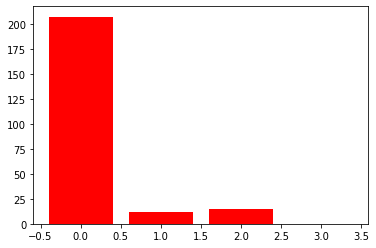

In [12]:
categories = customer_df.groupby("risk_rank").size().index
            
risk_rank_df = customer_df[["risk_rank", "sar_flag"]]

rrs_df = risk_rank_df.loc[risk_rank_df["sar_flag"] == 1]
rrs_series = fill_missing_group(rrs_df.groupby("risk_rank").size(), categories)

plt.bar(categories, rrs_series, color="red")
plt.show()

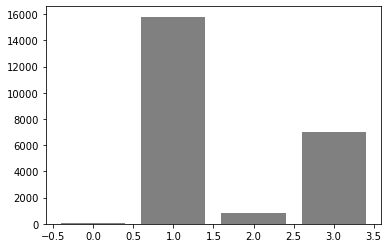

In [13]:
rrns_df = risk_rank_df.loc[risk_rank_df["sar_flag"] == 0]
rrns_series = fill_missing_group(rrns_df.groupby("risk_rank").size(), categories)

plt.bar(categories, rrns_series, color="gray")
plt.show()

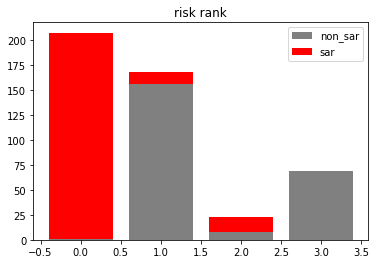

In [14]:
rrns_normalize_series = rrns_series * (len(rrs_df) / len(rrns_df))

plt.title("risk rank")
plt.bar(categories, rrns_normalize_series, color="gray", label="non_sar")
plt.bar(categories, rrs_series, bottom=rrns_normalize_series, color="red", label="sar")
plt.legend()
plt.show()

## Occupation Code

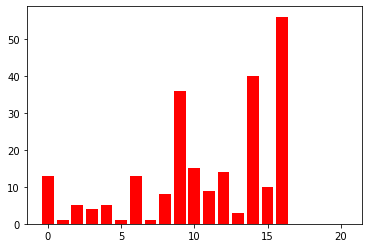

In [15]:
occupation_df = customer_df[["occupation_code", "sar_flag"]]
occ_categories = occupation_df.groupby("occupation_code").size().index

occs_df = occupation_df.loc[occupation_df.loc[:, "sar_flag"] == 1]
occs_series = fill_missing_group(occs_df.groupby("occupation_code").size(), occ_categories)

plt.bar(occ_categories, occs_series, color="red")
plt.show()

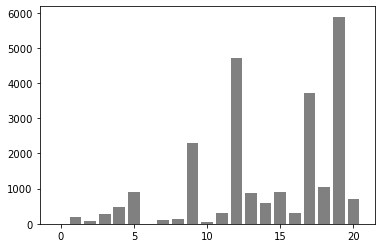

In [16]:
occns_df = occupation_df.loc[occupation_df.loc[:, "sar_flag"] == 0]
occns_series = fill_missing_group(occns_df.groupby("occupation_code").size(), occ_categories)

plt.bar(occ_categories, occns_series, color="grey")
plt.show()

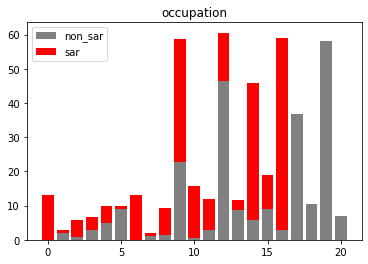

In [17]:
occns_normalize_series = occns_series * (len(occs_df) / len(occns_df))

plt.title("occupation")
plt.bar(occ_categories, occns_normalize_series, color="gray", label="non_sar")
plt.bar(occ_categories, occs_series, bottom=occns_normalize_series, color="red", label="sar")
plt.legend()
plt.show()

## Total Asset 



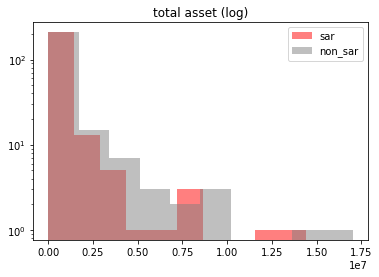

In [18]:
ta_df = customer_df[["total_asset", "sar_flag"]]
tas_df = ta_df.loc[ta_df.loc[:, "sar_flag"] == 1]
tans_df = ta_df.loc[ta_df.loc[:, "sar_flag"] == 0]

tans_df = tans_df.sample(n = 240)

kwargs = dict(alpha=0.5)
plt.title("total asset (log)")
plt.hist(tas_df["total_asset"], **kwargs, color = "red", label="sar", log = True)
plt.hist(tans_df["total_asset"], **kwargs, color = "grey", label="non_sar", log = True)
plt.legend()
plt.show()

## AGE

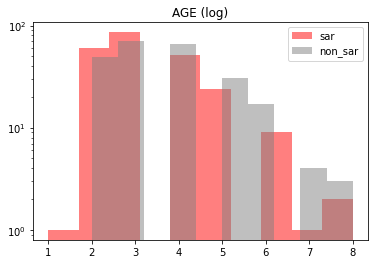

In [19]:
a_df = customer_df[["AGE", "sar_flag"]]
as_df = a_df.loc[a_df.loc[:, "sar_flag"] == 1]
ans_df = a_df.loc[a_df.loc[:, "sar_flag"] == 0]

ans_df = ans_df.sample(n = 240)

kwargs = dict(alpha=0.5)
plt.title("AGE (log)")
plt.hist(as_df["AGE"], **kwargs, color = "red", label="sar", log = True)
plt.hist(ans_df["AGE"], **kwargs, color = "grey", label="non_sar", log = True)
plt.legend()
plt.show()

# BaseLine 

precision:  0.05263157894736842
recall:  0.019230769230769232
f1 score:  0.028169014084507043


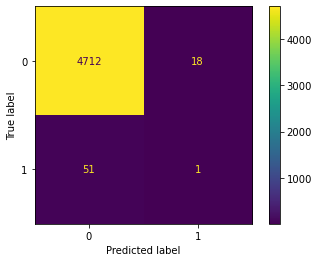

In [20]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay

dt_df = customer_df.copy()
X = dt_df[["risk_rank", "occupation_code", "total_asset", "AGE"]]
y = dt_df["sar_flag"]
X = X.fillna(99)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

dtc = DecisionTreeClassifier()
model = dtc.fit(X_train, y_train)

y_predict = model.predict(X_test)

print("precision: ", precision_score(y_test, y_predict))
print("recall: ", recall_score(y_test, y_predict))
print("f1 score: ", f1_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()


## Initial Thoughts
1. Many transactions on the same day seams suspicious



----

# Time Series

In [21]:
y_df = customer_df[['cust_id','sar_flag']].set_index('cust_id')

In [22]:
##pivot
cdtx_pivot = pd.pivot_table(cdtx_df, values='amt', index=['date'], columns=['cust_id'], aggfunc=np.sum)
cdtx_pivot = cdtx_pivot.fillna(0)
cdtx_pivot = cdtx_pivot[list(set(y_df.index) & set(cdtx_pivot.columns))]
cdtx_pivot

##you may use pd.resample to change frequency

cust_id,39d049baef9f1ba93cdf7d0e9ca93490ea0047f21cb189ff8ded31a7ceeaf146,fb234ed1e30578f8359a114678d91dca92a05687bc11c9dcdfe26978427bcc5c,5d0087f9a233064c7ef6684e363043c34c107c13dea3b41552893852acab6d69,f1d981ab44c5ea936af330370154376c44fa5f15210db11a5389dd0ddb63b267,ce1e4ec38146a5d5d2548ede959037a3ff94457060717186349c4259c2ebd504,d89e77559822feccbe5daf45ce24f3707271be86a490124aaf1f6d83a11280f7,359b844e7747a01f5cb51592fcd8627e0c86ce683ce39c36a2adc6590c7da16f,9711f2a15e7352e6bbaf12b63787d1a7583c71c448738e153ba929c4c2db3ece,a3f84cead246d36d4512704a034da6a7f678eab28fbb41824f24a61cd9c1ad51,bd0bf23ae7766aefc03715e47498116ad7592e5d03e64da0170a342cd5cd6537,...,1c69375556be3274c8b7a4e21bb8f216461cbaa4b6028c11576e0adf3feb1ebb,564a02ae7c066223b17b291f63a90c93c322de2476da09a10eaec1c15ca930b3,bd865cec13bafb4192a3fc05e1fbfd1e73a244c3c54d0472d082893640d0729a,a3b64eb45f5d034996ecab4a4236ea919129adc21925823be9c9f3d1673783cb,c3f030b3ef43a839a1e5692786b40f4347b1aa035f95b0067d8c8bbd350da816,ea955ee5fce36d505ca6b00b40586092112c8ff26d8d2ad35fff53559a341ed6,eb5b1a0ced14610a9989efe8bd6bd0a558f01c8126d4cdf690e473e2350e8db7,6ac01039f033f1b2624809c08e501f57944c27081f2a389c998ea7a6e0e8a301,cace9f2c08214ac73f5cc31b23026b4db76a18baeb84aa64696cd1fe15f4a348,548b051fcc062b5ea8dbeae1000b8e647d815b4dcec3b4437a70e2658d9a4fa1
date,,,,,,,,,,,,,,,,,,,,,
0,175.0,0.0,0.0,0.0,378.0,4618.0,0.0,0.0,511.0,0.0,...,0.0,0.0,50955.0,0.0,272.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,344.0,0.0,0.0,0.0,1207.0,0.0,...,0.0,0.0,20314.0,579.0,306.0,92.0,0.0,0.0,0.0,30.0
2,0.0,0.0,0.0,0.0,15579.0,19703.0,0.0,0.0,2211.0,0.0,...,0.0,0.0,21775.0,0.0,0.0,0.0,0.0,0.0,0.0,26612.0
3,0.0,0.0,2731.0,0.0,1673.0,0.0,413.0,0.0,1567.0,0.0,...,0.0,421.0,12055.0,0.0,337.0,0.0,0.0,0.0,0.0,36467.0
4,0.0,0.0,0.0,0.0,595.0,27758.0,0.0,0.0,1411.0,0.0,...,0.0,0.0,6372.0,0.0,672.0,0.0,0.0,0.0,0.0,4219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.0,0.0,0.0,0.0,370.0,3260.0,0.0,0.0,3212.0,0.0,...,22545.0,0.0,24793.0,0.0,0.0,0.0,1422.0,0.0,0.0,0.0
391,0.0,15.0,0.0,411.0,27098.0,43241.0,0.0,0.0,895.0,0.0,...,15030.0,497.0,45980.0,0.0,0.0,0.0,1024.0,0.0,0.0,0.0
392,0.0,0.0,0.0,339.0,419.0,9532.0,1519.0,0.0,693.0,0.0,...,0.0,0.0,17778.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
##pivot
dp_pivot = pd.pivot_table(dp_df, values='tx_amt', index=['tx_date'], columns=['cust_id'], aggfunc=np.sum)
dp_pivot = dp_pivot.fillna(0)
dp_pivot = dp_pivot[list(set(y_df.index) & set(dp_pivot.columns))]
dp_pivot

##you may use pd.resample to change frequency

cust_id,65c3ba8b8e412d0006881b3208a4dddee7c2b17f24cb6f2990530eb3d5a21407,39d049baef9f1ba93cdf7d0e9ca93490ea0047f21cb189ff8ded31a7ceeaf146,ce1e4ec38146a5d5d2548ede959037a3ff94457060717186349c4259c2ebd504,bd0bf23ae7766aefc03715e47498116ad7592e5d03e64da0170a342cd5cd6537,2812b1ea6f9efe33b3db4b3ba2c4b71b03e5f60878416b506d3b33ccdce9d5cb,b7c76effe9ac9e8cb949d2e4e67af4df92ae71709d8c15fa933325b16bc58c4c,d9cddb6c06d1fb01a9900a42d9eb2ad9e4ce2e9d2820384f1bb74f46412f2e75,c283452f1f3709ca013be332c926000decc8afba5d5ec2b5c51ac1858bbd5a66,e14f542b5ab44714ed4844b9042aa9a4f2ab869bcd20116ae1db729c44e41c9d,ad14ebf5eb2143f8fcf763ca02a913b5d69a928431d89d5ec2d51ee486d8fa36,...,e5b641cb0e5cc8de9d9fe78d0151dfb524abe3f78c0967aff572af56ef358252,7d327b677b9c3c8976ba7df631e92a9ff22240aef25af91584748ce2491b9d32,2e22a879a21e0d062b1173d3a33824b11a63ffcbe4b4fc150eaa31b70f53c7ff,9f69b7e19dcff28135ff1cae1449c0ef56255ebe85782eb65334c2620739e9ca,8d9a99ba0148eada513b476d60057d20507c89442881a05d770cb4c0bb1fd4d6,2b6a1a3d307787dbf4b9d7426394004486f94ac328784f676f913e18680d5200,c3f030b3ef43a839a1e5692786b40f4347b1aa035f95b0067d8c8bbd350da816,ea955ee5fce36d505ca6b00b40586092112c8ff26d8d2ad35fff53559a341ed6,d3decd8fad115274fba55bfdeadaaa877acf90d9bb24eb0125436f214148f178,2b1cdd7ab34c635baa33f930ef6067d1dc3b6bb4f6f8aa10ee17a0cabbb0546d
tx_date,,,,,,,,,,,,,,,,,,,,,
0,4705.0,0.0,978761.0,0.0,241597.0,0.0,0.0,0.0,0.0,0.0,...,5092.0,2881190.0,0.0,351027.0,0.0,0.0,63341.0,0.0,0.0,0.0
1,0.0,0.0,164745.0,0.0,0.0,0.0,0.0,0.0,20789.0,0.0,...,0.0,719.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10497.0,0.0,208406.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,48875.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.0,22561.0,278432.0,0.0,88132.0,0.0,0.0,0.0,2709573.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,164186.0
391,0.0,10102.0,0.0,0.0,314022.0,0.0,0.0,0.0,36957.0,0.0,...,0.0,844943.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70080.0
392,0.0,11259.0,0.0,0.0,265208.0,0.0,0.0,0.0,49943.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
y_df

,sar_flag
cust_id,
a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bfeb016d17b16f37a8d8,0
7e42b5dca9b28ee8e5545beb834361e90e6197d176b389718e6c99b10041c816,0
a6cdf6302aead77112013168c6d546d2df3bcb551956d22c96cf97652e581602,0
1a3efa69705f611c7ef2384a715c8142e2ee801cfec9df4eb21131c33fc247a7,0
67f8cbb64dd3d447e992b1b299e0ceed3372188e47c88e213b16abaedf6af700,0
...,...
b600c0720096c241f5aec16b096c6a353492eee8a5855aa7f79d81390811d914,0
06c5ea5ccda4dfd8839c0dec8646fb3071d2c02883ef8a9f715aaa74f38d2419,0
0c2dc5fedc3689abf5ff4be14fe8fea8d23d22068297c24bb3cbd245eaf8aa16,0


In [25]:
#pivot_dic = pivot.to_dict()
X_ts = dp_pivot.T.to_numpy()
y_ts = np.array([y_df.loc[i,'sar_flag'].max() for i in dp_pivot.columns])

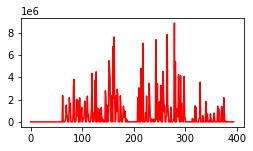

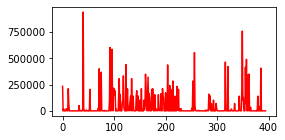

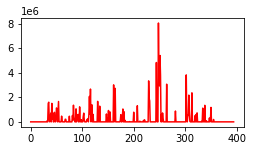

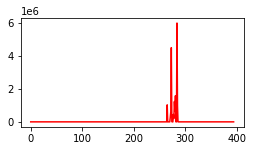

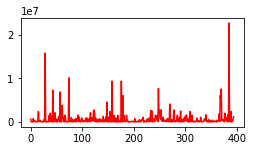

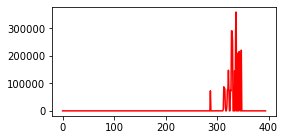

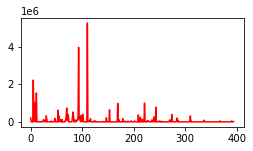

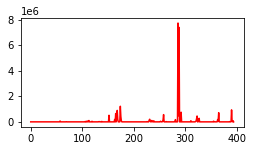

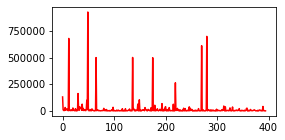

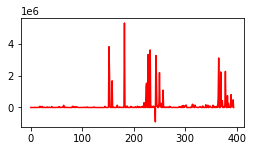

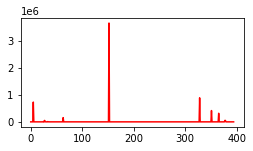

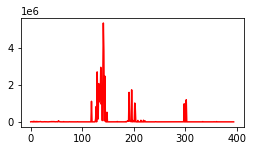

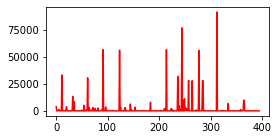

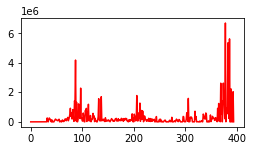

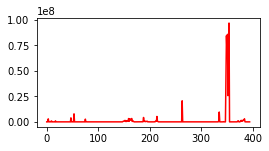

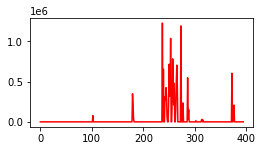

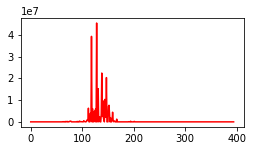

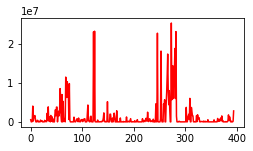

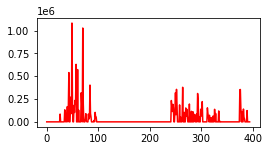

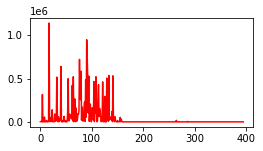

In [26]:
#abnormal
color_label = ['grey','red']
for i in range(500):
  if y_ts[i]==1:
    plt.figure(figsize=(4, 2))
    plt.plot(X_ts[i], color=color_label[y_ts[i]])

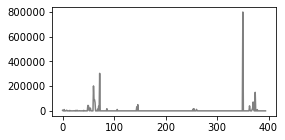

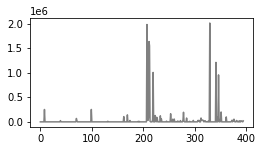

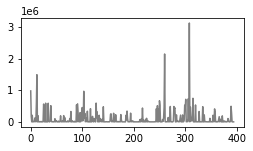

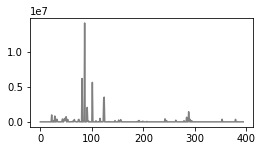

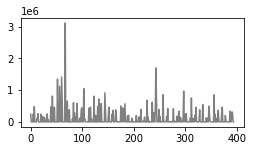

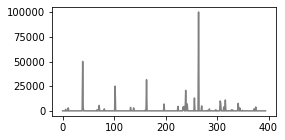

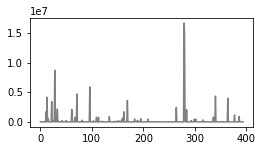

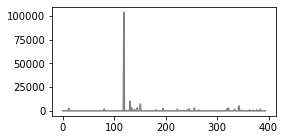

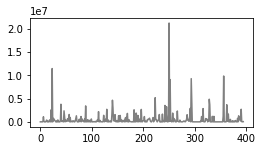

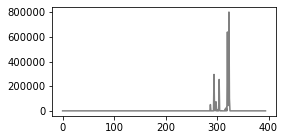

In [27]:
#normal
color_label = ['grey','red']
for i in range(10):
  if y_ts[i]==0:
    plt.figure(figsize=(4, 2))
    plt.plot(X_ts[i], color=color_label[y_ts[i]])

In [28]:
pd.Series(y_ts).value_counts()

0    5530
1     232
dtype: int64

# Autoencoder

In [29]:
#Coderef: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb#scrollTo=sOcfXfXq6FBd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

C:\Users\ASUS\anaconda3\lib\site-packages\requests\__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [30]:
# Download the dataset
dataframe = dp_pivot.T
raw_data = dataframe.values


In [31]:
# The last element contains the labels
labels = y_ts
len=dp_pivot.shape[0]

# The other data points are the electrocadriogram data
data = raw_data

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

In [32]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

In [33]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[~train_labels]
normal_test_data = test_data[~test_labels]

anomalous_train_data = train_data[train_labels]
anomalous_test_data = test_data[test_labels]

In [34]:
print(normal_train_data.shape)
print(anomalous_train_data.shape)

(4434, 395)
(175, 395)


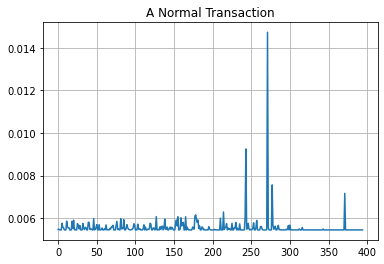

In [35]:
plt.grid()
plt.plot(np.arange(len), normal_train_data[100])
plt.title("A Normal Transaction")
plt.show()

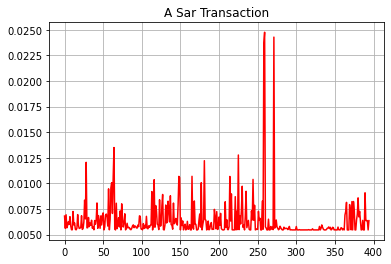

In [36]:
plt.grid()
plt.plot(np.arange(len), anomalous_train_data[5], color='r')
plt.title("A Sar Transaction")
plt.show()

### LSTM Autoencoder

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

In [37]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(128, activation="relu"),
      layers.Dense(64, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(64, activation="relu"),
      layers.Dense(128, activation="relu"),
      layers.Dense(len, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [38]:
autoencoder.compile(optimizer='adam', loss='mae')

In [39]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=50, 
          batch_size=128,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/50
35/35 [==============================] - 1s 7ms/step - loss: 0.4513 - val_loss: 0.2574
Epoch 2/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0427 - val_loss: 0.0055
Epoch 3/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0056
Epoch 6/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0055
Epoch 7/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 8/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0020
Epoch 9/50
35/35 [==============================] - 0s 3ms/step - loss: 0.0010 - val_loss: 5.6443e-04
Epoch 10/50
35/35 [==============================] - 0s 5ms/step - loss: 4.2240e-04 - val_loss: 3.7563e-04
Epoch 1

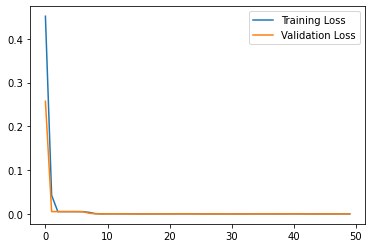

In [40]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

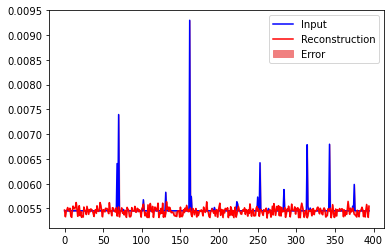

In [41]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

sample=100
plt.plot(normal_test_data[sample], 'b')
plt.plot(decoded_data[sample], 'r')
plt.fill_between(np.arange(len), decoded_data[sample], normal_test_data[sample], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

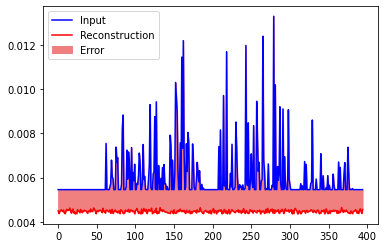

In [42]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(len), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

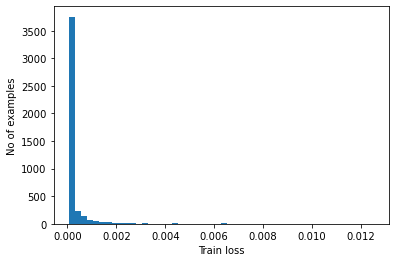

In [43]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [44]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.001025558


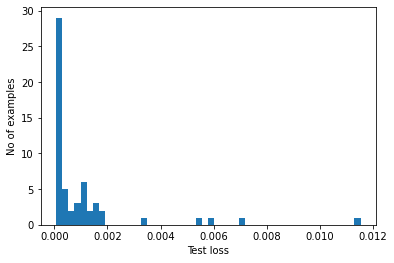

In [45]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [46]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [47]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.09193408499566348
Precision = 0.037383177570093455
Recall = 0.7017543859649122


# Statistic Value

In [48]:
from scipy.stats import skew, entropy
from numpy import inf

#basic stat of transaction
dp_pivot = pd.pivot_table(dp_df, values='tx_amt', index=['tx_date'], columns=['cust_id'], aggfunc=np.sum)
dp_pivot = dp_pivot.fillna(0)
stat = dp_pivot.describe().T
stat.head()


,count,mean,std,min,25%,50%,75%,max
cust_id,,,,,,,,
0015cc01f553512007705edf855baa16f1b57a16fb107e0882c5cb0535d297a5,395.0,7185.212658,106154.546178,0.0,0.0,0.0,0.0,2084353.0
002d6bc6382e759c9a5b6bb2c8dda9add2f38cd87e10ca3efda9a312e97b342c,395.0,635.708861,4564.788273,0.0,0.0,0.0,0.0,58370.0
002f13f534d0bd9fcc1848db3ff5c7b1179d117f8de8055b7394696b948ec9b4,395.0,40890.703797,316549.081859,0.0,0.0,0.0,0.0,4479327.0
0031e83ddef78e57d17ac5dce088627b7745be8ff6cffcbc0a79aff9fedd93f0,395.0,82508.726582,416442.718961,0.0,0.0,0.0,0.0,5826371.0
0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155b9bc5d18de6b65f381,395.0,171152.898734,557435.117722,0.0,0.0,2002.0,99120.5,6445011.0


In [49]:
stat.shape

(6196, 8)

In [50]:
#add entropy and skew
entropy_day = pd.DataFrame(dp_pivot.apply(entropy),columns=['entropy'])
entropy_day[entropy_day == -inf] = 0
skew_day = pd.DataFrame(dp_pivot.apply(skew), columns=['skew'])
stat = stat.join(entropy_day).join(skew_day)

C:\Users\ASUS\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [51]:
stat.shape

(6196, 10)

In [54]:
remit_df

,cust_id,trans_date,trans_no,trade_amount_usd
0,01b1735c3dbf0a35c1c989bb45434ce4326b365b73db06...,148,0,100528.0
1,01b1735c3dbf0a35c1c989bb45434ce4326b365b73db06...,165,0,100528.0
2,01b1735c3dbf0a35c1c989bb45434ce4326b365b73db06...,231,0,89479.0
3,01b1735c3dbf0a35c1c989bb45434ce4326b365b73db06...,291,0,100528.0
4,01b1735c3dbf0a35c1c989bb45434ce4326b365b73db06...,389,0,30158.0
...,...,...,...,...
17162,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,244,0,33788.0
17163,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,284,4,91318.0
17164,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,298,0,83201.0
17165,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,316,0,99233.0


In [55]:
# #add remit data
# remit_pivot = pd.pivot_table(remit_df, values='trade_amount_usd', index=['cust_id'], aggfunc=[len, np.mean, np.std, np.sum])
# remit_pivot.columns = ['remit_cnt','remit_mean','remit_std','remit_sum']

# #add cdtx data
# cdtx_df_stat_pivot = pd.pivot_table(cdtx_df, values='amt', index=['cust_id'], aggfunc=[len, np.mean, np.std, np.sum])
# cdtx_df_stat_pivot.columns = ['cdtx_cnt','cdtx_mean','cdtx_std','cdtx_sum']

# stat = stat.join(remit_pivot).fillna(0)
# stat = stat.join(cdtx_df_stat_pivot).fillna(0)
# stat = stat.round(3)

In [56]:
stat.shape

(6196, 10)

In [57]:
stat.head()

,count,mean,std,min,25%,50%,75%,max,entropy,skew
cust_id,,,,,,,,,,
0015cc01f553512007705edf855baa16f1b57a16fb107e0882c5cb0535d297a5,395.0,7185.212658,106154.546178,0.0,0.0,0.0,0.0,2084353.0,1.219469,19.100760
002d6bc6382e759c9a5b6bb2c8dda9add2f38cd87e10ca3efda9a312e97b342c,395.0,635.708861,4564.788273,0.0,0.0,0.0,0.0,58370.0,2.244040,9.555415
002f13f534d0bd9fcc1848db3ff5c7b1179d117f8de8055b7394696b948ec9b4,395.0,40890.703797,316549.081859,0.0,0.0,0.0,0.0,4479327.0,2.599460,12.728959
0031e83ddef78e57d17ac5dce088627b7745be8ff6cffcbc0a79aff9fedd93f0,395.0,82508.726582,416442.718961,0.0,0.0,0.0,0.0,5826371.0,3.332620,10.024504
0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155b9bc5d18de6b65f381,395.0,171152.898734,557435.117722,0.0,0.0,2002.0,99120.5,6445011.0,4.118233,6.081807


In [59]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from xgboost import XGBClassifier

def df_get_dummies(df,columns=[]):
  for col in columns:
    dummy = pd.get_dummies(df[col].fillna(0).astype(int))
    df_dummy = pd.concat([df, dummy], axis=1)
    df_dummy = df_dummy.drop(columns=col)
    return df_dummy

# #How many alert by cust_id
# alert_cnt = pd.pivot_table(customer_df, values='alert_key', index=['cust_id'], aggfunc=[len])

#clean duplicate cust_id
customer_df_unique = customer_df.drop_duplicates(subset=['cust_id'],keep='last')

dt_df = customer_df_unique[customer_df_unique.cust_id.isin(stat.index)].set_index('cust_id')
dt_df = df_get_dummies(dt_df,['occupation_code']).join(stat)

X = dt_df.drop(columns=['alert_key','sar_flag'])
y = dt_df["sar_flag"]


X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

precision:  0.04477611940298507
recall:  0.09090909090909091
f1 score:  0.06


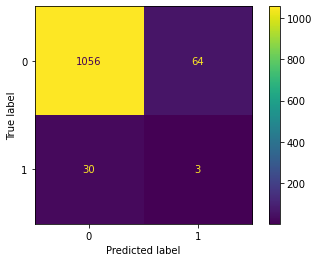

In [77]:
#Decision Tree
dtc = DecisionTreeClassifier()
model = dtc.fit(X_train, y_train)

y_predict = model.predict(X_test)

print("precision: ", precision_score(y_test, y_predict))
print("recall: ", recall_score(y_test, y_predict))
print("f1 score: ", f1_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

C:\Users\ASUS\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
precision:  0.0
recall:  0.0
f1 score:  0.0


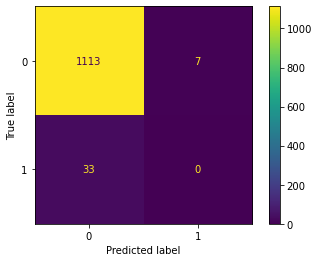

In [81]:
#Xgboost
xgb = XGBClassifier(n_estimators=100, learning_rate= 0.001)

xgb.fit(X_train, y_train)

y_predict = xgb.predict(X_test)

print("precision: ", precision_score(y_test, y_predict))
print("recall: ", recall_score(y_test, y_predict))
print("f1 score: ", f1_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

In [83]:
#Ridge
from sklearn.linear_model import Ridge
clf = Ridge(alpha=1.0)

clf.fit(X_train, y_train)

y_predict = clf.predict(X_test)

# print("precision: ", precision_score(y_test, y_predict))
# print("recall: ", recall_score(y_test, y_predict))
# print("f1 score: ", f1_score(y_test, y_predict))

# cm = confusion_matrix(y_test, y_predict)
# display = ConfusionMatrixDisplay(confusion_matrix = cm)
# display.plot()
print(clf.score(X_train, y_train, sample_weight=None))

0.047227678285391206


C:\Users\ASUS\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.30065e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


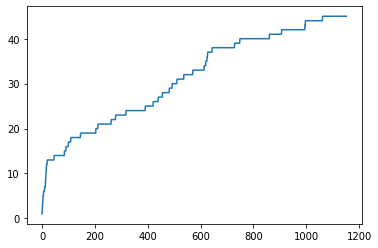

In [457]:
score = pd.DataFrame(xgb.predict_proba(X_test),columns=['nosar','sar'])
score['Y'] = y_test.values
score['Y_pred'] = y_predict
score = score.sort_values('sar',ascending=False)
plt.plot(list(score['Y'].cumsum()))

In [458]:
#One-class SVM
from sklearn import svm

X_oc = X.join(y)

X_good = X_oc[X_oc.sar_flag == 0].drop(columns=["sar_flag"])
X_sar = X_oc[X_oc.sar_flag == 1].drop(columns=["sar_flag"])

X_good_train, X_good_test = train_test_split(X_good,  test_size = 0.2)

# fit model nu: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors. Should be in the interval (0, 1]. 
clf = svm.OneClassSVM(nu=0.05, kernel="rbf", gamma=0.1)
clf.fit(X_good_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


OneClassSVM(gamma=0.1, nu=0.05)

In [400]:
y_pred_train = clf.predict(X_good_train) 
y_pred_test = clf.predict(X_good_test)   
y_pred_outliers = clf.predict(X_sar)
n_error_train = y_pred_train[y_pred_train == -1].size
n_error_test = y_pred_test[y_pred_test == -1].size
n_error_outliers = y_pred_outliers[y_pred_outliers == 1].size 

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [401]:
print('training_acc:',1-n_error_train/len(X_good_train))

training_acc: 0.2645729778581112


accuracy_score:  0.1721556886227545
precision:  0.17153558052434456
recall:  1.0
f1 score:  0.2928388746803069


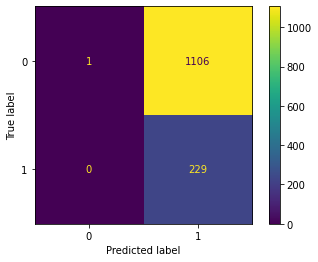

In [403]:
y_predict = list(y_pred_test)+list(y_pred_outliers)
y_predict = [1 if i == -1 else 0 for i in y_predict]
y_test = [0]*len(X_good_test) + [1]*len(X_sar)

accuracy_score
print("accuracy_score: ", accuracy_score(y_test, y_predict))
print("precision: ", precision_score(y_test, y_predict))
print("recall: ", recall_score(y_test, y_predict))
print("f1 score: ", f1_score(y_test, y_predict))

cm = confusion_matrix(y_test, y_predict)
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


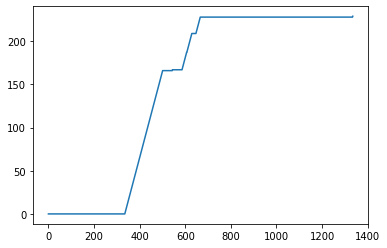

In [405]:
score = pd.DataFrame({'score':list(clf.score_samples(X_good_test))+list(clf.score_samples(X_sar))})
score['Y'] = y_test
score = score.sort_values('score',ascending=False)
plt.plot(list(score['Y'].cumsum()))

# make public prediction

In [436]:
public = pd.read_csv('./public_alert.csv')
custinfo_df_raw = pd.read_csv("./public_train_x_custinfo_full_hashed.csv")
public_key = list(public.alert_key)
cust_alert_dict = (custinfo_df[['cust_id','alert_key']].set_index('alert_key')).to_dict()
public.head()

,alert_key,probability
0,357307,0.000017
1,376329,0.000324
2,373644,0.000372
3,357668,0.000489
4,354443,0.000526


In [408]:
customer_df_unique = customer_df.drop_duplicates(subset=['cust_id'],keep='last')

dt_df = customer_df_unique[customer_df_unique.cust_id.isin(stat.index)].set_index('cust_id')
dt_df = df_get_dummies(dt_df,['occupation_code']).join(stat)

X = dt_df.drop(columns=['alert_key','sar_flag'])
y = dt_df["sar_flag"]

In [431]:
dt_df_public = custinfo_df_raw.set_index('cust_id')
dt_df_public = df_get_dummies(dt_df_public,['occupation_code']).join(stat)

X_public = dt_df_public[dt_df_public.alert_key.isin(public_key)]
alert_key_save = X_public.alert_key
X_public = X_public.drop(columns="alert_key")
X_public = X_public[X.columns]

X_public = X_public.fillna(0)

In [432]:
print('public key len:',len(public))
print('cust_info intersaction:',len(alert_key_save))
print('dp intersaction:', len(list(set(dp_pivot.columns) & set(dt_df_public[dt_df_public.alert_key.isin(public_key)].index))))
print('cdtx intersaction:', len(list(set(cdtx_pivot.columns) & set(dt_df_public[dt_df_public.alert_key.isin(public_key)].index))))
print('X_shape:',X_public.shape)

public key len: 3850
cust_info intersaction: 1845
dp intersaction: 706
cdtx intersaction: 167
X_shape: (1845, 36)


In [438]:
score_public = pd.DataFrame(xgb.predict_proba(X_public),columns=['nosar','sar'])
score_public['alert_key'] = alert_key_save.values
score_public = score_public.drop_duplicates()
score_public.sort_values('sar',ascending=False)

,nosar,sar,alert_key
1311,0.476648,0.523352,354569
233,0.476648,0.523352,362851
713,0.476648,0.523352,364687
712,0.476648,0.523352,364314
711,0.476648,0.523352,363764
...,...,...,...
884,0.545411,0.454589,360077
883,0.545411,0.454589,356420
882,0.545411,0.454589,360789
881,0.545411,0.454589,364693


In [244]:
score.to_csv('./preiction_result.csv')